In [2]:
print('ping')

ping


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import visualization
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
import sys
import os
import glob

import utils

In [8]:
def find_obj_in_sample(Obj_RA_Dec, Sample_RA_Dec, sep=0.0000001*u.deg, nsteps=5, verbose=True):
    coord = Obj_RA_Dec
    sep_step_up = 0.00000020*u.deg
    sep_step_down = 0.00000015*u.deg
    for i in range(nsteps):
        match_ind = np.argwhere(Sample_RA_Dec.separation(coord) < sep)
        if len(match_ind) < 1:
            sep += sep_step_up
        elif len(match_ind) > 1:
            sep -= sep_step_down
        elif len(match_ind) == 1:
            continue
    if len(match_ind) < 1:
        if verbose:
            print('No Matches within %.2e degrees' % sep.value)
        return()
    elif len(match_ind) > 1:
        if verbose:
            print('Multiple Matches within %.2e' % sep.value)
        return(match_ind)
    else:
        if verbose:
            print('MATCH FOUND!')
        match_ind = match_ind[0,0]
        match_sep = Sample_RA_Dec[match_ind].separation(coord).deg
        return(match_ind, match_sep)
    
def restore_observed_spectra(target, method):
    SpectraFile = target + '_' + method + '.npz'
    temp = np.load(SpectraDir + SpectraFile)
    obj = temp['obj']
    norm_spec = temp['norm_spec']
    spectral_err = temp['spec_err']
    RV = temp['RV']
    Obs_RA_Dec = SkyCoord(temp['RA_Dec'])
    temp.close()
    return(obj, norm_spec, spectral_err, RV, Obs_RA_Dec)

def restore_APOGEE_standards():
    temp = np.genfromtxt(Standards_Dir + 'APOGEEPayne_standards.txt', dtype=str)
    APOGEE_ID = temp[:,1]
    APOGEE_RA_Dec = SkyCoord([temp[i,1]+' '+temp[i,2] for i in range(len(temp))], unit=u.deg)
    Teff = temp[:,3]
    Logg = temp[:,4]
    MgH = temp[:,9]
    FeH = temp[:,18]
    Quality = temp[:,-1]
    return(APOGEE_ID, APOGEE_RA_Dec, Teff, Logg, MgH, FeH, Quality)

def restore_Kirby2010_standards(res='medium'):
    fname = Standards_Dir + 'Kirby2010_standards.txt'
    with open(fname) as f:
        temp = f.readlines()
    temp = temp[49:]
    temp = [x.strip() for x in temp]
    f.close()
    
    System = np.array([x[:15].replace(" ","") for x in temp])
    Name = np.array([x[15:29].replace(" ","") for x in temp])
    Ref = np.array([x[29:55].replace(" ","") for x in temp])
    RA = [x[55:66].strip().replace(" ",":") for x in temp]
    Dec = [x[66:78].strip().replace(" ",":") for x in temp]
    kirby_RA_Dec = SkyCoord(RA, Dec, unit=(u.hourangle,u.deg))
    
    if res == 'high':
        Teff = np.array([x[78:83].strip().replace(" ","") for x in temp],dtype=float)
        logg = np.array([x[83:88].strip().replace(" ","") for x in temp],dtype=float)
        Fe_H = np.array([x[93:99].strip().replace(" ","") for x in temp],dtype=float)
        Mg_Fe_temp = [x[104:110].strip().replace(" ","") for x in temp]
        Mg_Fe = np.array(['100' if x=='' else x for x in Mg_Fe_temp],dtype=float)
        Mg_Fe[Mg_Fe == 100] = np.nan
        Si_Fe_temp = [x[115:121].strip().replace(" ","") for x in temp]
        Si_Fe = np.array(['100' if x=='' else x for x in Si_Fe_temp],dtype=float)
        Si_Fe[Si_Fe == 100] = np.nan
        Ca_Fe_temp = [x[126:132].strip().replace(" ","") for x in temp]
        Ca_Fe = np.array(['100' if x=='' else x for x in Ca_Fe_temp],dtype=float)
        Ca_Fe[Ca_Fe == 100] = np.nan
        Ti_Fe_temp = [x[137:143].strip().replace(" ","") for x in temp]
        Ti_Fe = np.array(['100' if x=='' else x for x in Ti_Fe_temp],dtype=float)
        Ti_Fe[Ti_Fe == 100] = np.nan
    
    if res == 'medium':
        Teff = np.array([x[148:153].strip().replace(" ","") for x in temp],dtype=float)
        logg = np.array([x[153:158].strip().replace(" ","") for x in temp],dtype=float)
        Fe_H = np.array([x[163:169].strip().replace(" ","") for x in temp],dtype=float)
        Mg_Fe_temp = [x[174:180].strip().replace(" ","") for x in temp]
        Mg_Fe = np.array(['100' if x=='' else x for x in Mg_Fe_temp],dtype=float)
        Mg_Fe[Mg_Fe == 100] = np.nan
        Si_Fe_temp = [x[185:191].strip().replace(" ","") for x in temp]
        Si_Fe = np.array(['100' if x=='' else x for x in Si_Fe_temp],dtype=float)
        Si_Fe[Si_Fe == 100] = np.nan
        Ca_Fe_temp = [x[196:202].strip().replace(" ","") for x in temp]
        Ca_Fe = np.array(['100' if x=='' else x for x in Ca_Fe_temp],dtype=float)
        Ca_Fe[Ca_Fe == 100] = np.nan
        Ti_Fe_temp = [x[207:213].strip().replace(" ","") for x in temp]
        Ti_Fe = np.array(['100' if x=='' else x for x in Ti_Fe_temp],dtype=float)
        Ti_Fe[Ti_Fe == 100] = np.nan
        
    return(kirby_RA_Dec, System, Name, Teff, logg, Fe_H, Mg_Fe, Si_Fe, Ca_Fe, Ti_Fe)


def restore_Kirby2008_standards():
    fname = Standards_Dir + 'Kirby2008_standards.fit'
    hdul = fits.open(fname)
    
    RA = hdul[1].data['_RAJ2000']
    Dec = hdul[1].data['_DEJ2000']
    RA_Dec = SkyCoord(RA, Dec, unit=(u.deg,u.deg))
    cluster = hdul[1].data['Cluster']
    Teff = hdul[1].data['Teff']
    logg = hdul[1].data['log_g_']    
    FeH_M = hdul[1].data['__Fe_H_M']
    alphaFe_M = hdul[1].data['__a_Fe_M']
    FeH_H = hdul[1].data['__Fe_H_H']
    alphaFe_H = hdul[1].data['__a_Fe_H']
    
    return(RA_Dec, cluster, Teff, logg, FeH_M, alphaFe_M, FeH_H, alphaFe_H)

def restore_Mucciarelli2017_standards():
    fname = Standards_Dir+'Mucciarelli2017_standards.fit'
    hdul = fits.open(fname)
    
    RA = hdul[1].data['RAJ2000']
    Dec = hdul[1].data['DEJ2000']
    RA_Dec = SkyCoord(RA, Dec, unit=(u.deg,u.deg))
    Teff = hdul[1].data['Teff']
    logg = hdul[1].data['log_g_']
    v_micro = hdul[1].data['vt']
    Fe_H = hdul[1].data['__Fe_H_']
    Mg_Fe = hdul[1].data['__Mg_Fe_']
    Ca_Fe = hdul[1].data['__Ca_Fe_']
    Ti_Fe = hdul[1].data['__Ti_Fe_']
    
    return(RA_Dec, Teff, logg, v_micro, Fe_H, Mg_Fe, Ca_Fe, Ti_Fe)

# Restore Observations

In [9]:
method = 'Horne'
verbose = False

###########################################################################
# Set Directories
###########################################################################
D_PayneDir = utils.D_PayneDir
Standards_Dir = D_PayneDir+'other_data/standards/'
DEIMOS_Dir = '/global/scratch/nathan_sandford/DEIMOS/'
SpectraDir = DEIMOS_Dir + 'Sgr_dSph/obs_spectra/'

###########################################################################
# Select Targets
###########################################################################
# targets = ['m2', 'm13', 'm15','m71', 'ngc2419', 'ngc7006',
#            'pegdig', 'pegdig24', 'pegdig26', 'WLM']
targets = ['211SgS', '212SgS', '219SgS']

# Restore APOGEE standards
APOGEE_ID, APOGEE_RA_Dec, APOGEE_Teff, APOGEE_logg,\
    APOGEE_MgH, APOGEE_FeH, APOGEE_Quality = restore_APOGEE_standards()
# Restore Kirby+ 2008 standards 
kirby_RA_Dec, kirby_cluster, kirby_Teff, kirby_logg,\
    kirby_FeH_M, kirby_alphaFe_M, kirby_FeH_H, kirby_alphaFe_H \
    = restore_Kirby2008_standards()
# Restore Mucciarelli+ 2017 standards
Mucciarelli_RA_Dec, Mucciarelli_Teff, Mucciarelli_logg, Mucciarelli_v_micro, \
    Mucciarelli_Fe_H, Mucciarelli_Mg_Fe, Mucciarelli_Ca_Fe, Mucciarelli_Ti_Fe \
    = restore_Mucciarelli2017_standards()

# Check APOGEE Payne Sample



APOGEE SUMMARY: 211SgS
No Matches :(


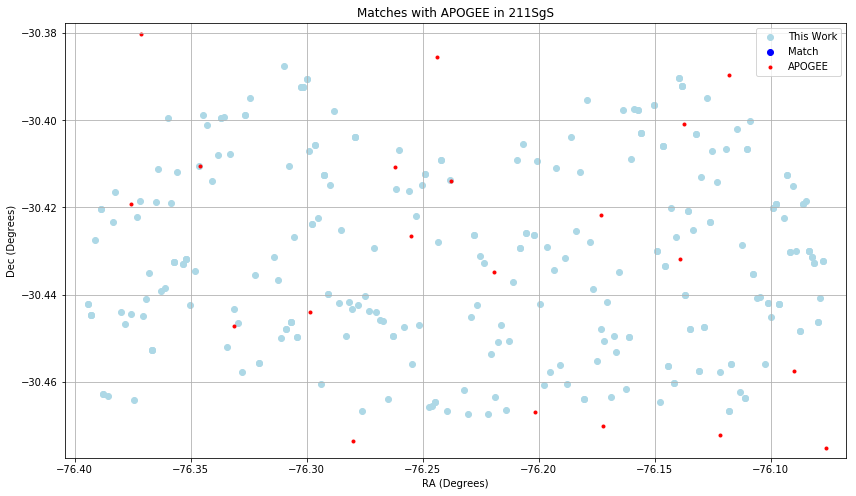



APOGEE SUMMARY: 212SgS
1 Matches found
Index: 172854
Object: #025.164Sgr
DEIMOS Index: 30
DEIMOS Star Coordinate
RA: -76.321917 deg
Dec: -30.483611 deg
APOGEE Star Coordinate
RA: -76.321850 deg
Dec: -30.483680 deg
Teff = 4480.2 K
Logg = 1.85
[Fe/H] = -1.31
[Mg/H] = -1.07



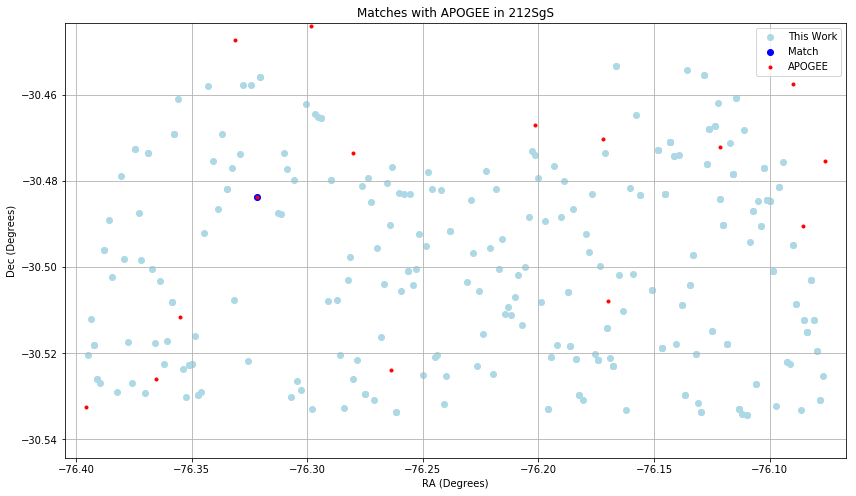



APOGEE SUMMARY: 219SgS
1 Matches found
Index: 172904
Object: #070.219Sgr
DEIMOS Index: 73
DEIMOS Star Coordinate
RA: -76.298667 deg
Dec: -30.443917 deg
APOGEE Star Coordinate
RA: -76.298580 deg
Dec: -30.444020 deg
Teff = 3850.6 K
Logg = 1.35
[Fe/H] = -0.10
[Mg/H] = -0.17



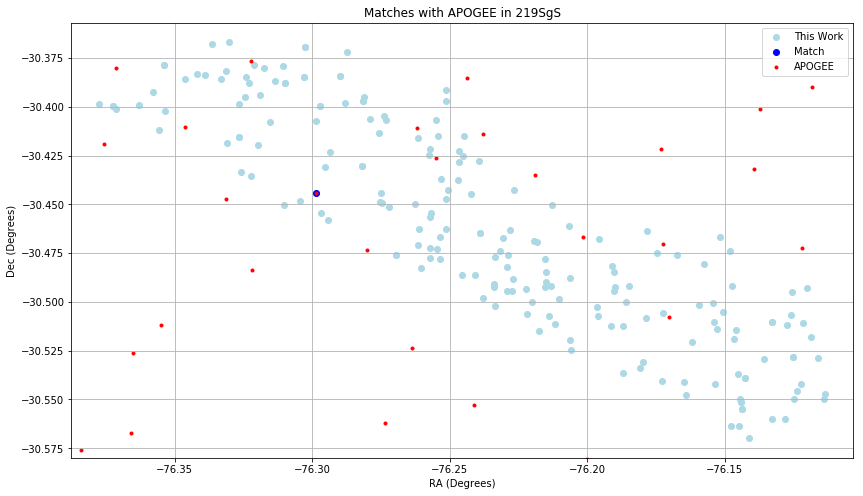

In [10]:
for target in targets:
    # Restore Observed Spectra
    obj, norm_spec, spectral_err, RV, Obs_RA_Dec = restore_observed_spectra(target, method)
        
    DEIMOS_ind = []
    APOGEE_ind = []
        
    for i in range(len(Obs_RA_Dec)):
        coord = Obs_RA_Dec[i]
        if obj[i][4:-1]=="serendip":
            if verbose:
                print('Skipping Serendip')
                print('')
            continue
        if verbose:
            print('Object #%s' % obj[i][4:])
            print('RA: %f' % coord.ra.deg)
            print('Dec: %f' % coord.dec.deg)
        try:
            match_ind, match_sep = find_obj_in_sample(Obj_RA_Dec=coord,
                                                     Sample_RA_Dec=APOGEE_RA_Dec,
                                                     verbose=verbose)
            APOGEE_ind.append(match_ind)
            if verbose:
                print('APOGEE ID: %s' % APOGEE_ID[match_ind])
                print('APOGEE Quality: %s' % APOGEE_Quality[match_ind])
                print('Separated by %.2e degrees' % match_sep)
                print('')
            DEIMOS_ind.append(i)
        except ValueError:
            if verbose:
                print('')
    
    print('\n\nAPOGEE SUMMARY: %s' % target)
    if len(APOGEE_ind)==0:
        print('No Matches :(')
    else:
        print('%i Matches found' % len(APOGEE_ind))
    for i in range(len(APOGEE_ind)):
        print('Index: %s' % APOGEE_ind[i])
        print('Object: #%s' % obj[DEIMOS_ind[i]])
        print('DEIMOS Index: %i' % DEIMOS_ind[i])
        print('DEIMOS Star Coordinate')
        print('RA: %f deg' % Obs_RA_Dec[DEIMOS_ind[i]].ra.wrap_at(180 * u.deg).deg)
        print('Dec: %f deg' % Obs_RA_Dec[DEIMOS_ind[i]].dec.wrap_at(180 * u.deg).deg)
        print('APOGEE Star Coordinate')
        print('RA: %f deg' % APOGEE_RA_Dec[APOGEE_ind[i]].ra.wrap_at(180 * u.deg).deg)
        print('Dec: %f deg' % APOGEE_RA_Dec[APOGEE_ind[i]].dec.wrap_at(180 * u.deg).deg)
        print('Teff = %s K' % APOGEE_Teff[APOGEE_ind[i]])
        print('Logg = %s' % APOGEE_logg[APOGEE_ind[i]])
        print('[Fe/H] = %s' % APOGEE_FeH[APOGEE_ind[i]])
        print('[Mg/H] = %s\n' % APOGEE_MgH[APOGEE_ind[i]])

    fig = plt.figure(figsize=(14,8))
    ax = fig.add_subplot(111)
    
    apogee_ra = APOGEE_RA_Dec.ra.wrap_at(180 * u.deg).deg
    
    obs_ra  = Obs_RA_Dec.ra.wrap_at(180 * u.deg).deg
    min_ra, max_ra = [np.min(obs_ra[np.abs(obs_ra) > 0.001]),np.max(obs_ra[np.abs(obs_ra) > 0.001])]
    min_dec, max_dec = [np.min(Obs_RA_Dec.dec.deg[np.abs(Obs_RA_Dec.dec.deg) > 0.001]),
                        np.max(Obs_RA_Dec.dec.deg[np.abs(Obs_RA_Dec.dec.deg) > 0.001])]
    
    ax.scatter(obs_ra, Obs_RA_Dec.dec.deg, marker='o',c='lightblue', label='This Work')
    ax.scatter(obs_ra[DEIMOS_ind], Obs_RA_Dec.dec.deg[DEIMOS_ind], marker='o',c='blue', label='Match')
    ax.scatter(apogee_ra, APOGEE_RA_Dec.dec.deg, marker='.',c='r', label='APOGEE')
    
    plt.grid(True)
    plt.xlim(min_ra - 0.01, max_ra + 0.01)
    plt.ylim(min_dec - 0.01, max_dec + 0.01)
    plt.xlabel('RA (Degrees)')
    plt.ylabel('Dec (Degrees)')
    plt.title('Matches with APOGEE in %s' % target)
    plt.legend()
    plt.show()

# Check Mucciarelli 2017 Sgr dSph



Mucciarelli SUMMARY: 211SgS
68 Matches found


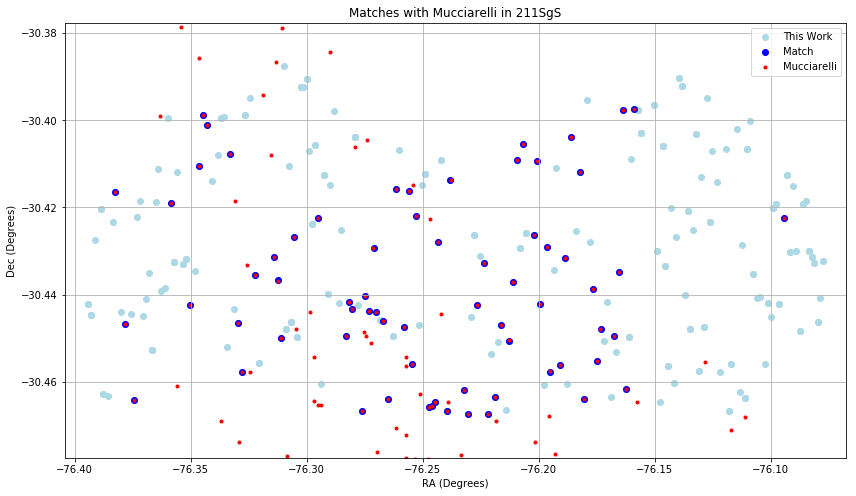



Mucciarelli SUMMARY: 212SgS
98 Matches found


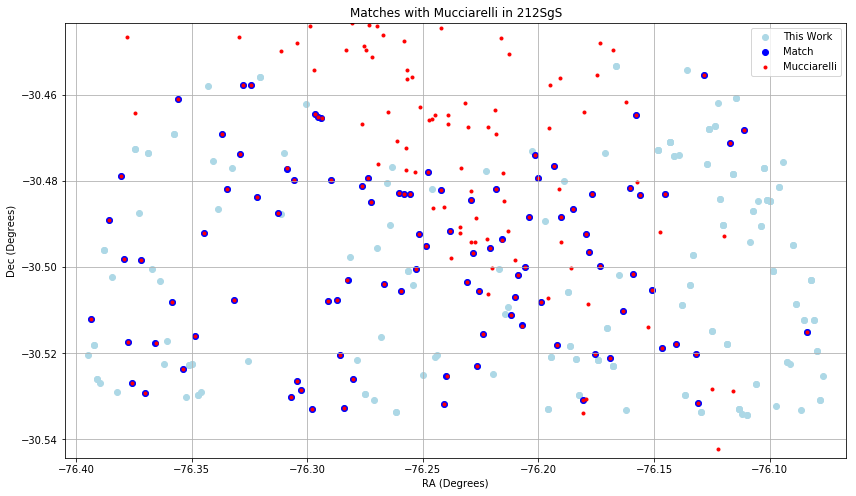



Mucciarelli SUMMARY: 219SgS
80 Matches found


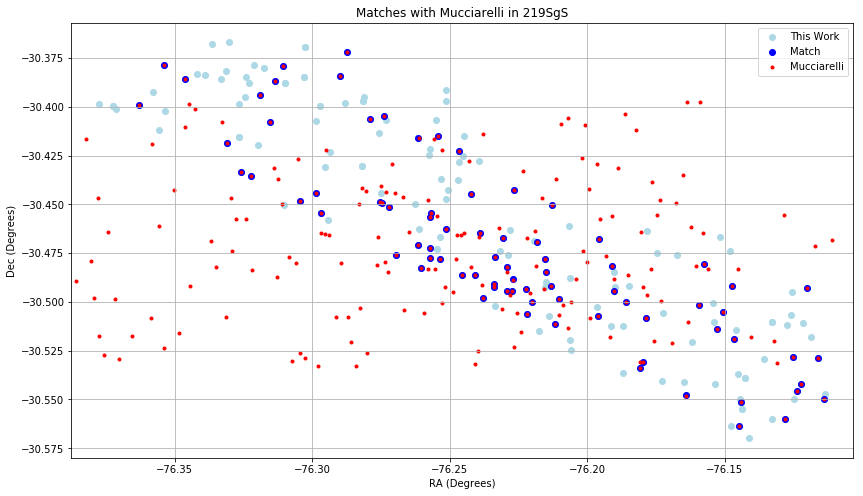

In [11]:
for target in targets:
    # Restore Observed Spectra
    obj, norm_spec, spectral_err, RV, Obs_RA_Dec = restore_observed_spectra(target, method)
        
    DEIMOS_ind = []
    Mucciarelli_ind = []
        
    for i in range(len(Obs_RA_Dec)):
        coord = Obs_RA_Dec[i]
        if obj[i][4:-1]=="serendip":
            if verbose:
                print('Skipping Serendip')
                print('')
            continue
        if verbose:
            print('Object #%s' % obj[i][4:])
            print('RA: %f' % coord.ra.deg)
            print('Dec: %f' % coord.dec.deg)
        try:
            match_ind, match_sep = find_obj_in_sample(Obj_RA_Dec=coord,
                                                     Sample_RA_Dec=Mucciarelli_RA_Dec,
                                                     verbose=verbose)
            Mucciarelli_ind.append(match_ind)
            if verbose:
                print('Separated by %.2e degrees \n' % match_sep)
            DEIMOS_ind.append(i)
        except ValueError:
            if verbose:
                print('')
    
    print('\n\nMucciarelli SUMMARY: %s' % target)
    if len(Mucciarelli_ind)==0:
        print('No Matches :(')
    else:
        print('%i Matches found' % len(Mucciarelli_ind))
    if verbose:
        for i in range(len(Mucciarelli_ind)):
            print('Index: %i' % Mucciarelli_ind[i])
            print('Object: #%s' % obj[DEIMOS_ind[i]])
            print('DEIMOS Index: %i' % DEIMOS_ind[i])
            print('DEIMOS Star Coordinate')
            print('RA: %f deg' % Obs_RA_Dec[DEIMOS_ind[i]].ra.wrap_at(180 * u.deg).deg)
            print('Dec: %f deg' % Obs_RA_Dec[DEIMOS_ind[i]].dec.wrap_at(180 * u.deg).deg)
            print('Mucciarelli Star Coordinate')
            print('RA: %f deg' % Mucciarelli_RA_Dec[Mucciarelli_ind[i]].ra.wrap_at(180 * u.deg).deg)
            print('Dec: %f deg' % Mucciarelli_RA_Dec[Mucciarelli_ind[i]].dec.wrap_at(180 * u.deg).deg)
            print('Teff = %s K' % Mucciarelli_Teff[Mucciarelli_ind[i]])
            print('Logg = %s' % Mucciarelli_logg[Mucciarelli_ind[i]])
            print('v_micro = %s' % Mucciarelli_v_micro[Mucciarelli_ind[i]])
            print('[Fe/H] = %s' % Mucciarelli_Fe_H[Mucciarelli_ind[i]])
            print('[Mg/Fe] = %s' % Mucciarelli_Mg_Fe[Mucciarelli_ind[i]])
            print('[Ca/Fe] = %s' % Mucciarelli_Ca_Fe[Mucciarelli_ind[i]])
            print('[Ti/Fe] = %s\n' % Mucciarelli_Ti_Fe[Mucciarelli_ind[i]])
    
    np.savez('Mucciarelli_Matches_'+target,
             DEIMOS_indices=DEIMOS_ind, Mucciarelli_indices=Mucciarelli_ind,
             Teff=Mucciarelli_Teff[Mucciarelli_ind], logg=Mucciarelli_logg[Mucciarelli_ind],
             v_micro=Mucciarelli_v_micro[Mucciarelli_ind], Fe_H=Mucciarelli_Fe_H[Mucciarelli_ind],
             Mg_Fe=Mucciarelli_Mg_Fe[Mucciarelli_ind], Ca_Fe=Mucciarelli_Ca_Fe[Mucciarelli_ind],
             Ti_Fe=Mucciarelli_Ti_Fe[Mucciarelli_ind])
    
    fig = plt.figure(figsize=(14,8))
    ax = fig.add_subplot(111)
    
    mucciarelli_ra = Mucciarelli_RA_Dec.ra.wrap_at(180 * u.deg).deg
    
    obs_ra  = Obs_RA_Dec.ra.wrap_at(180 * u.deg).deg
    min_ra, max_ra = [np.min(obs_ra[np.abs(obs_ra) > 0.001]),np.max(obs_ra[np.abs(obs_ra) > 0.001])]
    min_dec, max_dec = [np.min(Obs_RA_Dec.dec.deg[np.abs(Obs_RA_Dec.dec.deg) > 0.001]),
                        np.max(Obs_RA_Dec.dec.deg[np.abs(Obs_RA_Dec.dec.deg) > 0.001])]
    
    ax.scatter(obs_ra, Obs_RA_Dec.dec.deg, marker='o',c='lightblue', label='This Work')
    ax.scatter(obs_ra[DEIMOS_ind], Obs_RA_Dec.dec.deg[DEIMOS_ind], marker='o',c='blue', label='Match')
    ax.scatter(mucciarelli_ra, Mucciarelli_RA_Dec.dec.deg, marker='.',c='r', label='Mucciarelli')
    
    plt.grid(True)
    plt.xlim(min_ra - 0.01, max_ra + 0.01)
    plt.ylim(min_dec - 0.01, max_dec + 0.01)
    plt.xlabel('RA (Degrees)')
    plt.ylabel('Dec (Degrees)')
    plt.title('Matches with Mucciarelli in %s' % target)
    plt.legend()
    plt.show()

# Check Kirby 2008 GC's

In [ ]:
for target in targets:
    # Restore observed spectra
    obj, norm_spec, spectral_err, RV, Obs_RA_Dec = restore_observed_spectra(target, method)
    
    DEIMOS_ind = []
    kirby_ind = []
        
    for i in range(len(Obs_RA_Dec)):
        coord = Obs_RA_Dec[i]
        if any(char.isalpha() for char in obj[i]):
            if verbose:
                print('Skipping Serendip')
                print('')
            continue
        if verbose:
            print('Object #%s' % obj[i][4:])
            print('RA: %f' % coord.ra.deg)
            print('Dec: %f' % coord.dec.deg)
        try:
            match_ind, match_sep = find_obj_in_sample(Obj_RA_Dec=coord,
                                                     Sample_RA_Dec=kirby_RA_Dec,
                                                     verbose=verbose)
            kirby_ind.append(match_ind)
            if verbose:
                print('Name: %i' % Name[match_ind])
                print('Separated by %.2e degrees' % match_sep)
                print('')
            DEIMOS_ind.append(i)
        except ValueError:
            if verbose:
                print('')
    
    print('\n\nKirby SUMMARY: %s' % target)
    if len(kirby_ind)==0:
        print('No Matches :(')
    else:
        print('%i Matches found' % len(kirby_ind))
        for i in range(len(kirby_ind)):
            print('Index: %i' % DEIMOS_ind[i])
            print('Object: #%s' % obj[DEIMOS_ind[i]])
            print('DEIMOS Index: %i' % DEIMOS_ind[i])
            print('DEIMOS Star Coordinate')
            print('RA: %f deg' % Obs_RA_Dec[DEIMOS_ind[i]].ra.wrap_at(180 * u.deg).deg)
            print('Dec: %f deg' % Obs_RA_Dec[DEIMOS_ind[i]].dec.wrap_at(180 * u.deg).deg)
            print('kirby 2008+ Star Coordinate')
            print('RA: %f deg' % kirby_RA_Dec[kirby_ind[i]].ra.wrap_at(180 * u.deg).deg)
            print('Dec: %f deg' % kirby_RA_Dec[kirby_ind[i]].dec.wrap_at(180 * u.deg).deg)
            print('Teff = %s K' % kirby_Teff[kirby_ind[i]])
            print('Logg = %s' % kirby_logg[kirby_ind[i]])
            print('[Fe/H]_M = %s' % kirby_FeH_M[kirby_ind[i]])
            print('[alpha/H]_M = %s' % kirby_alphaFe_M[kirby_ind[i]])
            print('[Fe/H]_H = %s' % kirby_FeH_H[kirby_ind[i]])
            print('[alpha/H]_H = %s\n' % kirby_alphaFe_H[kirby_ind[i]])
            
    fig = plt.figure(figsize=(14,8))
    ax = fig.add_subplot(111)
    
    kirby_ra = kirby_RA_Dec.ra.wrap_at(180 * u.deg).deg
    
    obs_ra  = Obs_RA_Dec.ra.wrap_at(180 * u.deg).deg
    min_ra, max_ra = [np.min(obs_ra[np.abs(obs_ra) > 0.001]),np.max(obs_ra[np.abs(obs_ra) > 0.001])]
    min_dec, max_dec = [np.min(Obs_RA_Dec.dec.deg[np.abs(Obs_RA_Dec.dec.deg) > 0.001]),
                        np.max(Obs_RA_Dec.dec.deg[np.abs(Obs_RA_Dec.dec.deg) > 0.001])]
    
    ax.scatter(obs_ra, Obs_RA_Dec.dec.deg, marker='o',c='lightblue', label='This Work')
    ax.scatter(obs_ra[DEIMOS_ind], Obs_RA_Dec.dec.deg[DEIMOS_ind], marker='o',c='blue', label='Match')
    ax.scatter(kirby_ra, kirby_RA_Dec.dec.deg, marker='.',c='r', label='Kirby+ 2008')
    
    plt.grid(True)
    plt.xlim(min_ra - 0.1, max_ra + 0.1)
    plt.ylim(min_dec - 0.1, max_dec + 0.1)
    plt.xlabel('RA (Degrees)')
    plt.ylabel('Dec (Degrees)')
    plt.title('Matches with Kirby+ 2008 in %s' % target)
    plt.legend()
    plt.show()